In [1]:
from deeplab3.dataloaders.datasets.cityscapes import CityscapesSegmentation
from deeplab3.dataloaders import custom_transforms as tr
from deeplab3.dataloaders.utils import decode_segmap
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

from types import SimpleNamespace

Loading RGB-D and segmentation
-------

The depth and RGB are saved as seperate jpg files. Each is loaded seperately, then they are concatenated into a 4-channel image with the depth channel takeing the place of an alpha channel. All four channels are normalized and a random crop, horizontal flip, and gaussian blur are applied for image augmentation. The same transformation are applied to the segmentation mask.

Let's start by looking at a batch of 4 images and segmentation masks.

In [2]:
from deeplab3.config.defaults import get_cfg_defaults
cfg = get_cfg_defaults()
cfg.merge_from_file('configs/cityscapes_rgbd.yaml')

In [ ]:
def display_grid(images, labels):
    
    n = len(labels)
    plt.figure(figsize=(16, 4))
    
    for ii in range(n):
        plt.subplot('1{}{}'.format(n, ii+1))
        plt.imshow(images[ii])
        plt.title(labels[ii])
        plt.axis('off')

Using RGB-D input
Found 500 val images


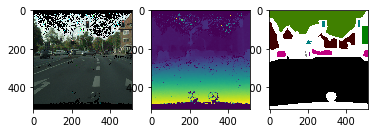

In [3]:
#Same as main method of dataloaders.datasets.coco
city_val = CityscapesSegmentation(cfg, split='val')

dataloader = DataLoader(city_val, batch_size=1, shuffle=True, num_workers=0)

for ii, sample in enumerate(dataloader):
    for jj in range(sample["image"].size()[0]):
        img_tmp = city_val.loader.invert_normalization(sample['image'].squeeze())
        gt = sample['label'].numpy()
        tmp = np.array(gt[jj]).astype(np.uint8)
        segmap = decode_segmap(tmp, dataset='coco')
        
        imgs = [img_tmp[:,:,:3], img_tmp[:,:,3:], segmap]
        labels = ['RGB', 'Depth', 'Labels']
        display_grid(imgs, labels)

    break

plt.show(block=True)

Load a saved model and visualize results
-----

The trained model takes the RGB-D image as input and produces a segmentation mask

In [4]:
import torch
import os
from deeplab3.dataloaders import make_data_loader
from deeplab3.modeling.sync_batchnorm.replicate import patch_replication_callback
from deeplab3.modeling import load_model

In [5]:
from deeplab3.config.defaults import get_cfg_defaults
cfg_rgbd = get_cfg_defaults()
cfg_rgbd.merge_from_file("configs/cityscapes_rgbd.yaml")
cfg_rgbd.merge_from_list(['SYSTEM.GPU_IDS', [0],
                          'TRAIN.RESUME', True, 
                          'RESUME.DIRECTORY', 'run/cityscapes/cityscapes_rgbd_resnet_deeplab/2020-03-30c/',
                         ])

cfg_rgb = get_cfg_defaults()
cfg_rgb.merge_from_file("configs/cityscapes_rgb.yaml")
cfg_rgb.merge_from_list(['SYSTEM.GPU_IDS', [0],
                         'TRAIN.RESUME', True, 
                         'RESUME.DIRECTORY', 'run/cityscapes/cityscapes_rgb/experiment_1/',
                         ])

rgbd_model = load_model(cfg_rgbd)
rgb_model = load_model(cfg_rgb)

rgbd_model.eval()
rgb_model.eval()

Training backbone from scratch
=> loaded checkpoint 'run/cityscapes/cityscapes_rgbd_resnet_deeplab/2020-03-30c/checkpoint.pth.tar' (epoch 163)
Training backbone from scratch
=> loaded checkpoint 'run/cityscapes/cityscapes_rgb/experiment_1/checkpoint.pth.tar' (epoch 83)


DataParallel(
  (module): DeepLab(
    (backbone): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): SynchronizedBatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, trac

In [6]:
def run_model(cfg, image, model):
    if cfg.SYSTEM.CUDA:
        image= image.cuda()
    with torch.no_grad():
        output = model(image)
        
    pred = output.data.cpu().numpy()
    pred = np.argmax(pred, axis=1)
    return pred
        
def display_prediction_grid(image, target):
    pred_rgb = run_model(cfg_rgb, image[:,:3,:,:], rgb_model)
    pred_rgbd = run_model(cfg_rgbd, image, rgbd_model)
    image = city_val.loader.invert_normalization(image.squeeze())
    
    segmap = decode_segmap(target.numpy().squeeze(), dataset='cityscapes')
    segmap_rgbd = decode_segmap(pred_rgbd.squeeze(), dataset='cityscapes')
    segmap_rgb = decode_segmap(pred_rgb.squeeze(), dataset='cityscapes')
    
    images = [image[:, :, :3], image[:, :, 3:].squeeze(), segmap, segmap_rgb, segmap_rgbd]
    labels = ['RGB', 'Depth', 'GT', 'RGB prediction', 'RGBD prediction']
    display_grid(images, labels)

['road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic_light', 'traffic_sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle']


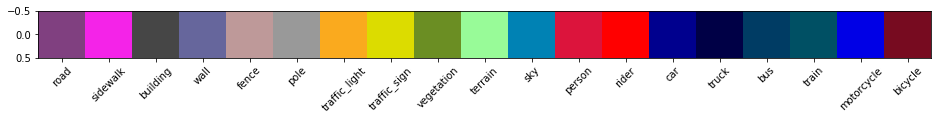

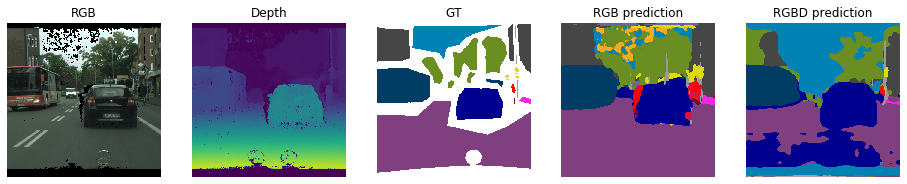

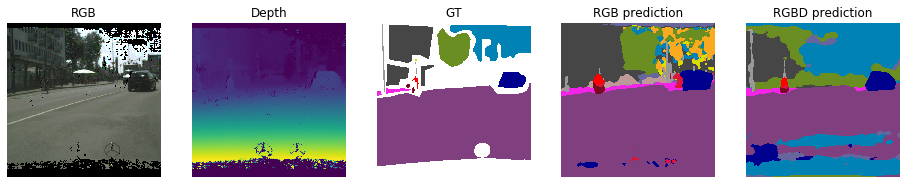

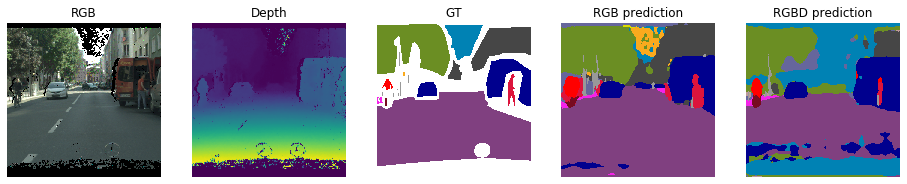

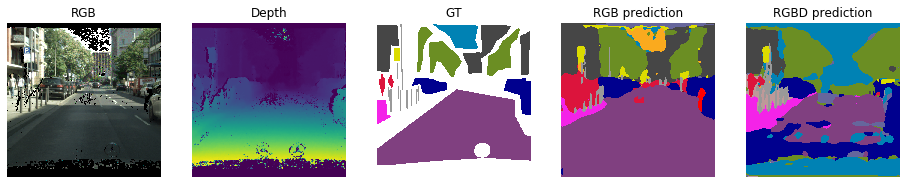

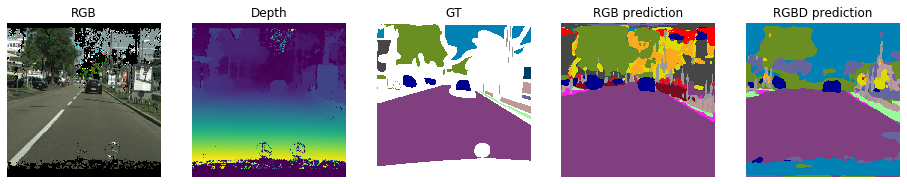

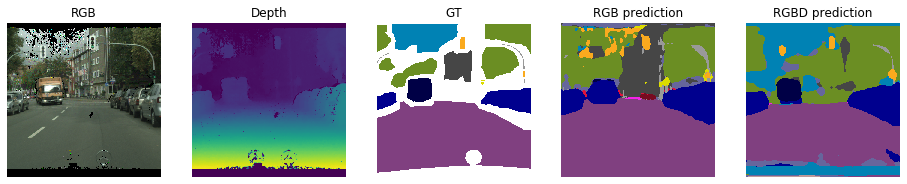

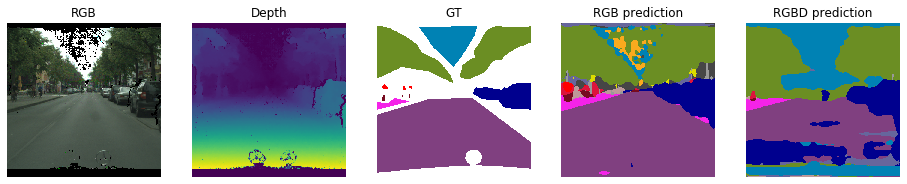

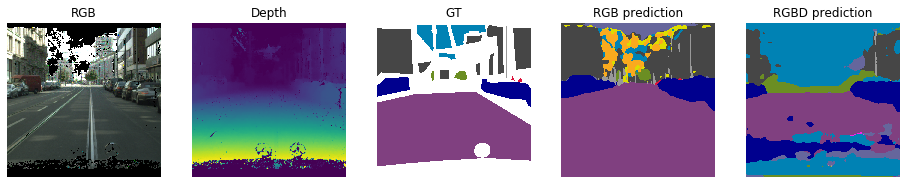

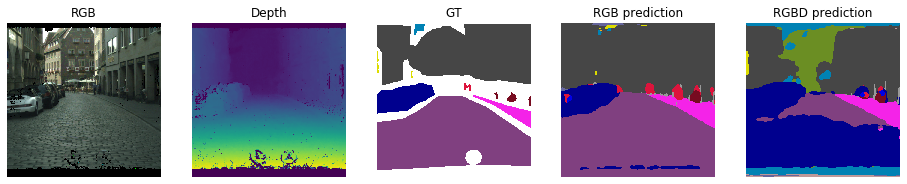

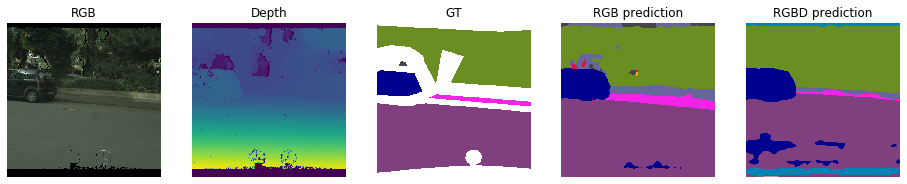

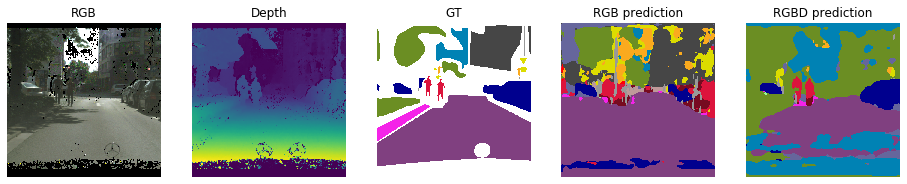

In [7]:
from deeplab3.dataloaders.utils import get_cityscapes_labels

#Class colors for reference
labels = city_val.loader.class_names

plt.figure(figsize=(16, 1))
plt.imshow(np.expand_dims(get_cityscapes_labels(), 0))
plt.xticks(range(len(labels)), labels, rotation=45)
print(labels)

# Test images 

for ii, sample in enumerate(dataloader):
    image, target = sample['image'], sample['label']
    display_prediction_grid(image, target)
    
    if ii==10:
        break

plt.show(block=True)


Convolutional Filter Visualization
--------

Code modified from https://colab.research.google.com/github/Niranjankumar-c/DeepLearning-PadhAI/blob/master/DeepLearning_Materials/6_VisualizationCNN_Pytorch/CNNVisualisation.ipynb

In [8]:
import torch.nn as nn

def sub2ind(array_shape, rows, cols):
    return rows*array_shape[1] + cols + 1

def plot_filters_single_channel(t, fig):
    
    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 4
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])

def plot_filters_multi_channel(t, fig, num_cols=2, current_col=0):
    
    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #rows = num of kernels
    num_rows = num_kernels

    #looping through all the kernels
    for i in range(t.shape[0]):
#         if i == 0:
#             print(t[i])
        ind = sub2ind((num_rows, num_cols), i, current_col)
        ax1 = fig.add_subplot(num_rows,num_cols,ind)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        #TODO Is this normalization the correct way of visualizing? 
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        if len(t.shape) == 4:
            npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])   
    
def plot_weights(layer):
  
  #checking whether the layer is convolution layer or not 
  if isinstance(layer, nn.Conv2d):
    #getting the weight tensor data
    weight_tensor = layer.weight.data.cpu()
    
    #set the figure size
    num_cols = 2
    num_rows = weight_tensor.shape[0]
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    plot_filters_multi_channel(weight_tensor[:,:3, :, :], fig)
    plot_filters_multi_channel(weight_tensor[:, 3, :, :], fig, current_col=1)
        
  else:
    print("Can only visualize layers which are convolutional")                          
  
  plt.tight_layout()
  plt.show()

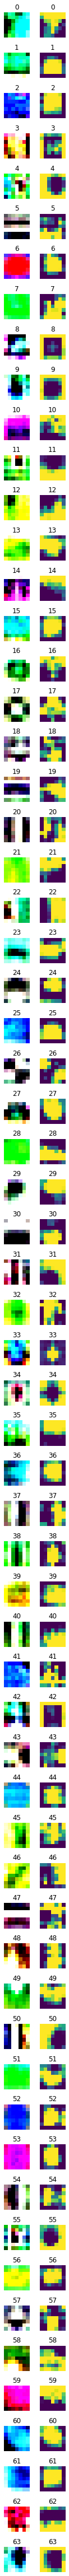

In [9]:
#visualize weights for model - first conv layer
plot_weights(rgbd_model.module.backbone.conv1)


Depth Ablation Study
-----

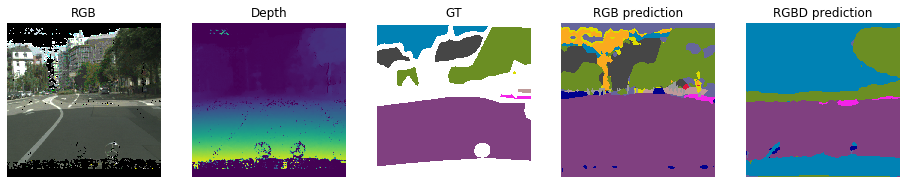

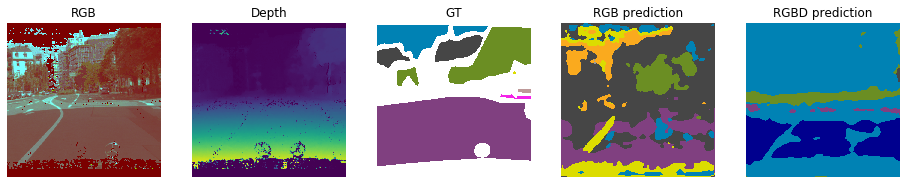

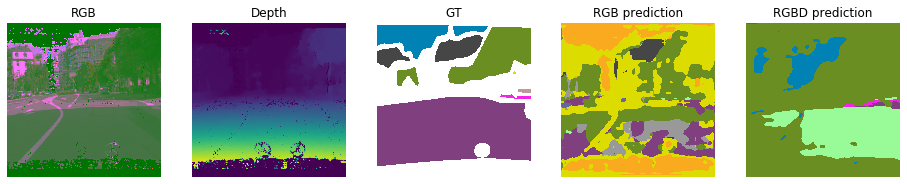

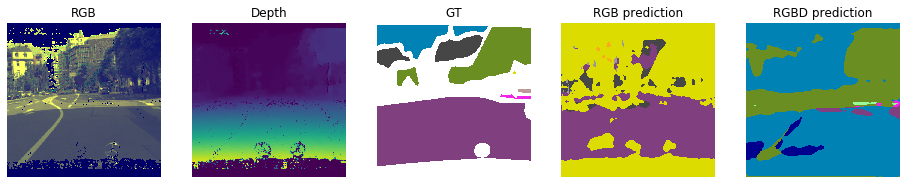

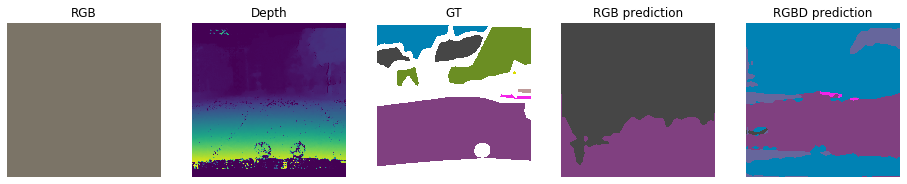

In [14]:
dataloader = DataLoader(city_val, batch_size=1, shuffle=True, num_workers=0)

for ii, sample in enumerate(dataloader):
    image, target = sample['image'], sample['label']
    display_prediction_grid(image.clone(), target)
    
    # Remove one channel
    channel_name = ['No red', 'no green', 'no blue', 'no depth']
    for jj in range(3):
        temp_image = image.clone()
        temp_image[:, jj, :, :] = 0
        display_prediction_grid(temp_image, target)
    
    # Depth only
    d_image = image.clone()
    d_image[:, 0:3, :, :] = 0
    display_prediction_grid(d_image, target)

    break

plt.show(block=True)

Loss Comparison
----


In [15]:
from deeplab3.test import Tester

test_rgbd = Tester(cfg_rgbd)
dataloader = DataLoader(city_val, batch_size=4, shuffle=True, num_workers=0)
output, mat = test_rgbd.run(dataloader, city_val.loader.NUM_CLASSES)

Training backbone from scratch


:   0%|          | 0/125 [00:00<?, ?it/s]

=> loaded checkpoint 'run/cityscapes/cityscapes_rgbd_resnet_deeplab/2020-03-30c/checkpoint.pth.tar' (epoch 163)


Test loss: 0.316:   0%|          | 0/125 [00:00<?, ?it/s]/home/cc/pytorch-deeplab-xception/deeplab3/utils/metrics.py:26: RuntimeWarning: invalid value encountered in true_divide
  np.diag(confusion_matrix))
Test loss: 0.293: 100%|██████████| 125/125 [01:57<00:00,  1.06it/s]


In [27]:
test_rgb = Tester(cfg_rgb)
dataloader = make_data_loader(cfg_rgb)[1]
output, mat = test_rgb.run(dataloader, city_val.loader.NUM_CLASSES)

Training backbone from scratch




:   0%|          | 0/63 [00:00<?, ?it/s]

=> loaded checkpoint 'run/cityscapes/cityscapes_rgb/experiment_1/checkpoint.pth.tar' (epoch 83)
Using RGB input
Found 19997 train_extra images
Using RGB input
Found 500 val images
Using RGB input
Found 1525 test images




Test loss: 0.002:   0%|          | 0/63 [00:01<?, ?it/s]

Test loss: 0.002:   2%|▏         | 1/63 [00:01<01:22,  1.33s/it]

Test loss: 0.003:   2%|▏         | 1/63 [00:02<01:22,  1.33s/it]

Test loss: 0.003:   3%|▎         | 2/63 [00:02<01:21,  1.33s/it]

Test loss: 0.003:   3%|▎         | 2/63 [00:03<01:21,  1.33s/it]

Test loss: 0.003:   5%|▍         | 3/63 [00:03<01:19,  1.32s/it]

Test loss: 0.004:   5%|▍         | 3/63 [00:05<01:19,  1.32s/it]

Test loss: 0.004:   6%|▋         | 4/63 [00:05<01:18,  1.33s/it]

Test loss: 0.003:   6%|▋         | 4/63 [00:06<01:18,  1.33s/it]

Test loss: 0.003:   8%|▊         | 5/63 [00:06<01:17,  1.33s/it]

Test loss: 0.003:   8%|▊         | 5/63 [00:07<01:17,  1.33s/it]

Test loss: 0.003:  10%|▉         | 6/63 [00:07<01:15,  1.33s/it]

Test loss: 0.004:  10%|▉         | 6/63 [00:08<01:15,  1.33s/it]

Test loss: 0.004:  11%|█         | 7/63 [00:09<01:14,  1.32s/it]

Test loss: 0.004:  11%|█         | 7/63 [00:10<01:14,  1.32s/it]

Test loss: 0.004

Test loss: 0.014:  89%|████████▉ | 56/63 [01:15<00:09,  1.32s/it]

Test loss: 0.014:  90%|█████████ | 57/63 [01:15<00:07,  1.33s/it]

Test loss: 0.014:  90%|█████████ | 57/63 [01:16<00:07,  1.33s/it]

Test loss: 0.014:  92%|█████████▏| 58/63 [01:17<00:06,  1.33s/it]

Test loss: 0.014:  92%|█████████▏| 58/63 [01:18<00:06,  1.33s/it]

Test loss: 0.014:  94%|█████████▎| 59/63 [01:18<00:05,  1.32s/it]

Test loss: 0.014:  94%|█████████▎| 59/63 [01:19<00:05,  1.32s/it]

Test loss: 0.014:  95%|█████████▌| 60/63 [01:19<00:03,  1.32s/it]

Test loss: 0.014:  95%|█████████▌| 60/63 [01:20<00:03,  1.32s/it]

Test loss: 0.014:  97%|█████████▋| 61/63 [01:21<00:02,  1.32s/it]

Test loss: 0.014:  97%|█████████▋| 61/63 [01:22<00:02,  1.32s/it]

Test loss: 0.014:  98%|█████████▊| 62/63 [01:22<00:01,  1.32s/it]

Test loss: 0.014:  98%|█████████▊| 62/63 [01:22<00:01,  1.32s/it]

Test loss: 0.014: 100%|██████████| 63/63 [01:23<00:00,  1.32s/it]


RGBD: {'iou': 0.86657692544313, 'accuracy': 0.9938493176294635}
RGB: {'iou': 0.854461400037317, 'accuracy': 0.9946282794291768}


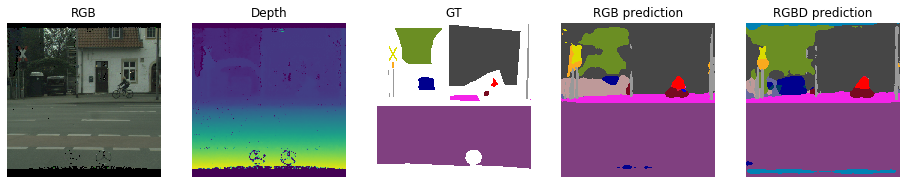

RGBD: {'iou': 0.377312614785616, 'accuracy': 0.9336656059077251}
RGB: {'iou': 0.6464602446245192, 'accuracy': 0.9887178861698471}


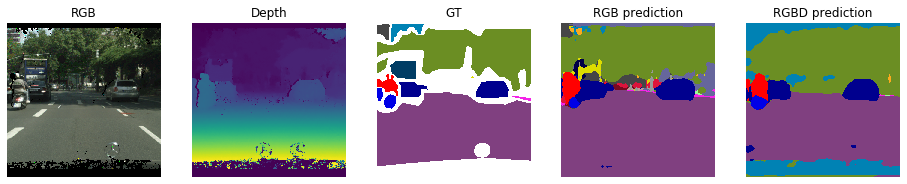

RGBD: {'iou': 0.5978058655719874, 'accuracy': 0.9266613290632506}
RGB: {'iou': 0.9010524055645798, 'accuracy': 0.9721377101681346}


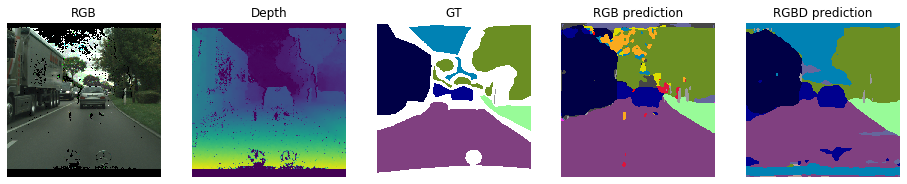

RGBD: {'iou': 0.45413984517379785, 'accuracy': 0.9250550520004289}
RGB: {'iou': 0.5671115527641785, 'accuracy': 0.9804864370015423}


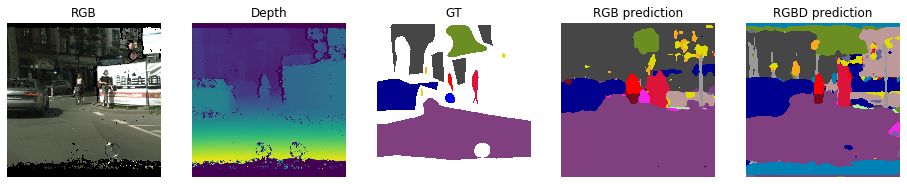

RGBD: {'iou': 0.45680379141923433, 'accuracy': 0.923230877535941}
RGB: {'iou': 0.7190753683287384, 'accuracy': 0.9948044845501778}


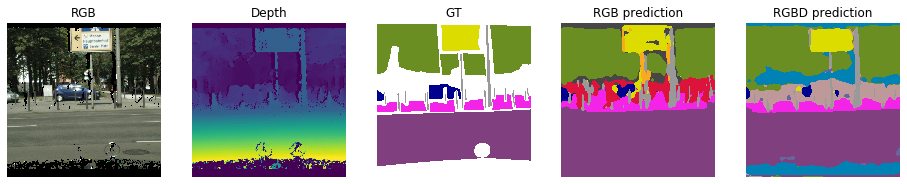

RGBD: {'iou': 0.3548480148777641, 'accuracy': 0.9122895622895623}
RGB: {'iou': 0.8182915988978444, 'accuracy': 0.9953513630932985}


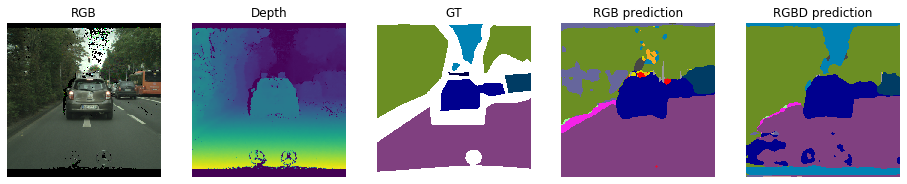

RGBD: {'iou': 0.6014686190244283, 'accuracy': 0.9119711344987756}
RGB: {'iou': 0.6895205917505873, 'accuracy': 0.9773072961783222}


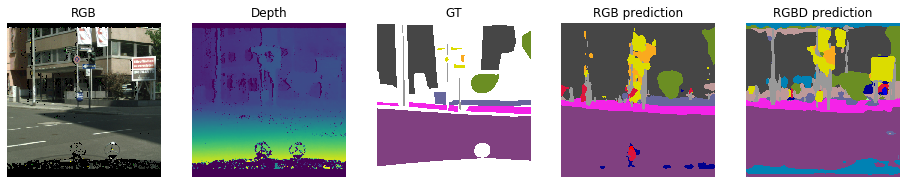

RGBD: {'iou': 0.3476833122143501, 'accuracy': 0.9115136644827856}
RGB: {'iou': 0.6662694213334582, 'accuracy': 0.992070162616481}


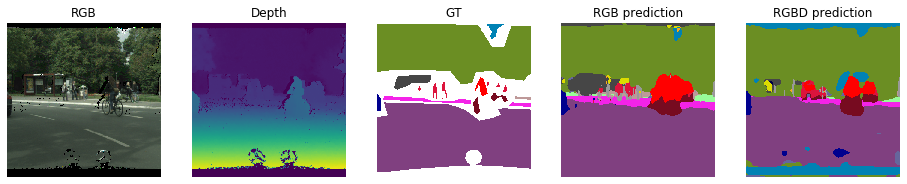

RGBD: {'iou': 0.39881453889882484, 'accuracy': 0.9102300507741491}
RGB: {'iou': 0.557201574247051, 'accuracy': 0.9931736977371027}


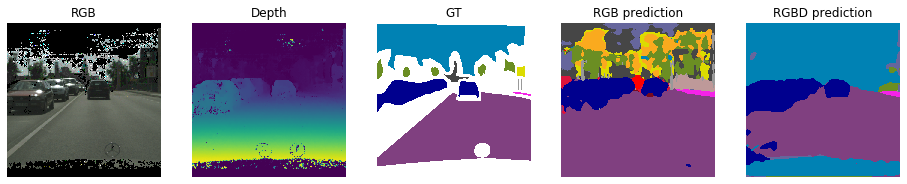

RGBD: {'iou': 0.3342546358461556, 'accuracy': 0.9076819877109662}
RGB: {'iou': 0.8179133668620514, 'accuracy': 0.9983954493010276}


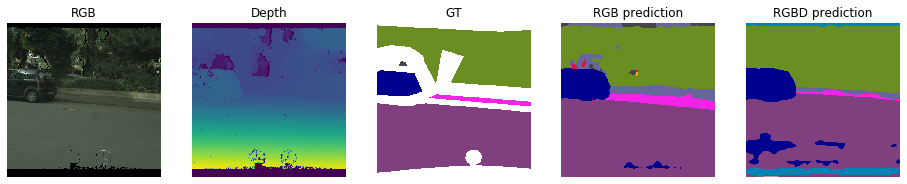

In [33]:
top = test_rgbd.img_evaluator.top_n()

for accuracy, img_list in top['accuracy'].items():
    for img_path in img_list:
        lbl_path = os.path.join(city_val.annotations_base,
                                    img_path.split(os.sep)[-2],
                                    os.path.basename(img_path)[:-15] + '{}_labelIds.png'.format(city_val.cfg.DATASET.CITYSCAPES.GT_MODE))

        depth_path = os.path.join(city_val.depth_base,
                                    img_path.split(os.sep)[-2],
                                    os.path.basename(img_path)[:-15] + '{}.png'.format(city_val.cfg.DATASET.CITYSCAPES.DEPTH_DIR))

        sample = city_val.loader.load_sample(img_path, depth_path, lbl_path)

        image, target = sample['image'].unsqueeze(0), sample['label'].unsqueeze(0)
        print('RGBD: {}'.format(test_rgbd.img_evaluator.image_stats[img_path]))
        print('RGB: {}'.format(test_rgb.img_evaluator.image_stats[img_path]))
        display_prediction_grid(image, target)
        plt.show()